In [156]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis

%matplotlib inline

#for interactive plots
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
pd.__version__

'0.20.3'

In [160]:
# Set path to folder containing Subject data Dictionaries
# path = '../Data_dict/' #dictionaries data Mac - (local, much faster)
path = '/Volumes/RTO/CIS-PD Study/Data_dict/' #Mac
# path = r'W:\CIS-PD Study\Data_dict' #windows repo path

#path to subject scores
pathscores = '../Scores/' #local
# pathscores = r'W:\CIS-PD Study\Scores' #windows repo path
#---------------------------------------------------------------------------------------------------------

In [161]:
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000, plt_ax=None):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    rawdata = pd.DataFrame(acts[activity][trial]).loc[data, sensor]#[start:end]
    #reindex time (relative to start)
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    rawdata.plot(figsize=(8,6),ax=plt_ax)

In [162]:
#list subjects in db
d = os.listdir(path)
f = [filename[:4] for filename in d if filename.startswith('1')]
print(np.sort(f))

['1004' '1016' '1018' '1019' '1020' '1024' '1029' '1030' '1032' '1038'
 '1044' '1046' '1049' '1052']


## Choose subject, task, visit and sensor location

In [163]:
subj = 1046 #choose subj to visualize

In [164]:
#load Pickle file dict
subj_filename = str(subj) + 'dict.pkl'
f = open(os.path.join(path, subj_filename), 'rb')
act_dict = pickle.load(f)
f.close()

In [165]:
#choose task, trials(visits) and sensor location
# task = 'Motor #8: Typing on a Computer'
# task_scores = 'Typing on a computer keyboard' #the task name in the scores file
task =  'Motor #5: Alternating Hand Movements'
# task_scores = 'Alternating left hand movements'
task_scores = 'Alternating right hand movements'
# task = 'Motor #3: Walking while Counting'
# task_scores = 'Walking while counting'
# task = 'Motor #2: Walking'
# task_scores = 'Walking'

side = 'right' #side score to use
# side = 'left' #side score to use

trials = [0,1,2,3,4,5,6]

## Scores for current subject

In [166]:
#load subject scores
mot_scores = pd.read_excel(os.path.join(pathscores, 'MotorTasks.xls'))
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

#change 1 month label to 4 wks for proper sorting
mot_scores.loc[mot_scores['Visit']=='1 Month','Visit']='4 Weeks'

#extract scores for corresponding task, subject and side
subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                            task_scores+ ' ' + 'tremor ' + side + ' upper limb',
                            task_scores+ ' ' + 'overall score']]
#rename cols
subj_score = subj_score.rename(index=str,
                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor', 
                                       subj_score.columns[4]:'overall'})
subj_score.index = range(len(subj_score))
subj_score


,Subject,Visit,Bradykinesia,Tremor,overall
0,1046,2 Weeks: Time 0,1,0,1
1,1046,2 Weeks: Time 30,1,0,1
2,1046,2 Weeks: Time 60,1,0,1
3,1046,2 Weeks: Time 90,1,0,1
4,1046,2 Weeks: Time 120,1,0,1
5,1046,2 Weeks: Time 150,1,0,1


In [ ]:
# #extract both sides scores for corresponding task and subject
# subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
#                             task_scores+ ' ' + 'bradykinesia right upper limb',
#                             task_scores+ ' ' + 'tremor right upper limb',
#                             task_scores+ ' ' + 'bradykinesia left upper limb',
#                             task_scores+ ' ' + 'tremor left upper limb',
#                             task_scores+ ' ' + 'overall score']]
# subj_score = subj_score.rename(index=str,
#                                columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right', 
#                                        subj_score.columns[4]:'Bradykinesia left',subj_score.columns[5]:'Tremor left',
#                                        subj_score.columns[6]:'overall'})


## Histogram of scores for specific task and all subjects 

In [ ]:
#histogram of motor scores from all subjects for current task
S = mot_scores[[            task_scores+ ' ' + 'bradykinesia right upper limb',
                            task_scores+ ' ' + 'tremor right upper limb',
                            task_scores+ ' ' + 'bradykinesia left upper limb',
                            task_scores+ ' ' + 'tremor left upper limb',
                            task_scores+ ' ' + 'overall score']]

S = S.rename(index=str,columns={S.columns[0]:'Bradykinesia right',S.columns[1]:'Tremor right', 
                                       S.columns[2]:'Bradykinesia left',S.columns[3]:'Tremor left',
                                       S.columns[4]:'overall'})
sns.set_context('paper',font_scale=1.5)
ax = S.hist(figsize=(20,20),xlabelsize=12,ylabelsize=12)

# Raw sensors data visualization - single subject
### plot all trials data from either one side or both sides

In [180]:
act_dict[task][3]

{'anterior_thigh_left': {'accel': Empty DataFrame
  Columns: [Accel X (g), Accel Y (g), Accel Z (g)]
  Index: [], 'elec': Empty DataFrame
  Columns: []
  Index: [], 'gyro': Empty DataFrame
  Columns: [Gyro X (°/s), Gyro Y (°/s), Gyro Z (°/s)]
  Index: []}, 'anterior_thigh_right': {'accel': Empty DataFrame
  Columns: [Accel X (g), Accel Y (g), Accel Z (g)]
  Index: [], 'elec': Empty DataFrame
  Columns: []
  Index: [], 'gyro': Empty DataFrame
  Columns: [Gyro X (°/s), Gyro Y (°/s), Gyro Z (°/s)]
  Index: []}, 'distal_lateral_shank_left': {'accel': Empty DataFrame
  Columns: [Accel X (g), Accel Y (g), Accel Z (g)]
  Index: [], 'elec': Empty DataFrame
  Columns: []
  Index: [], 'gyro': Empty DataFrame
  Columns: [Gyro X (°/s), Gyro Y (°/s), Gyro Z (°/s)]
  Index: []}, 'distal_lateral_shank_right': {'accel': Empty DataFrame
  Columns: [Accel X (g), Accel Y (g), Accel Z (g)]
  Index: [], 'elec': Empty DataFrame
  Columns: []
  Index: [], 'gyro': Empty DataFrame
  Columns: [Gyro X (°/s), Gyr

IndexError: index 0 is out of bounds for axis 0 with size 0

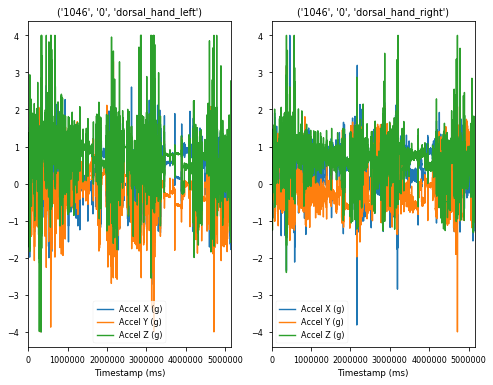

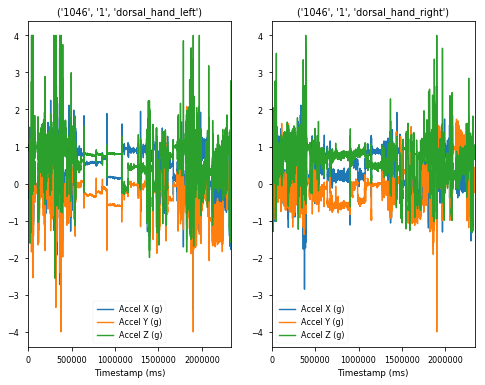

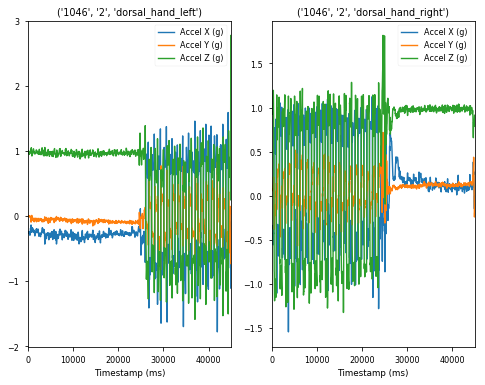

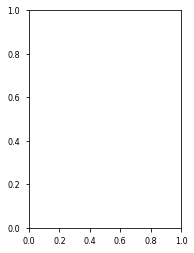

In [167]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'accel',plt_ax=ax1)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'accel',plt_ax=ax2)
    ax2.set_title('testR')
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))

In [ ]:
#plot one side only
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],loc,'accel')
    plt.title(tuple([str(subj)])+t+tuple([loc]))

# Plot raw data from all subjects for a given task and trial

In [41]:
#choose task, trials(visits) and sensor location
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'
trial = 3

In [42]:
#list subjects in db
d = os.listdir(path)
all_f = [filename[:4] for filename in d if filename.startswith('1')]
print(np.sort(all_f))

['1004' '1016' '1018' '1019' '1020' '1024' '1029' '1030' '1032' '1044'
 '1046' '1049' '1052']


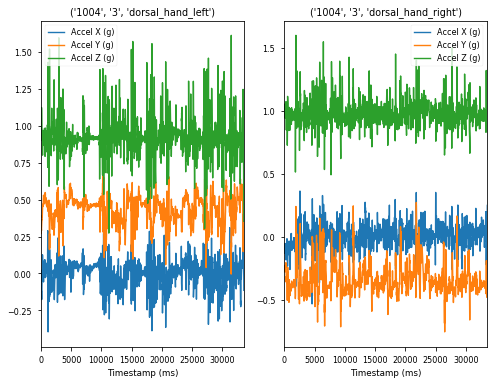

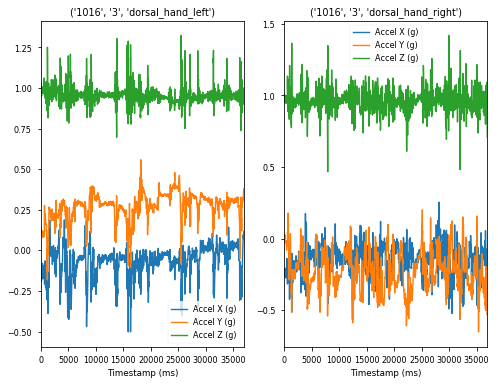

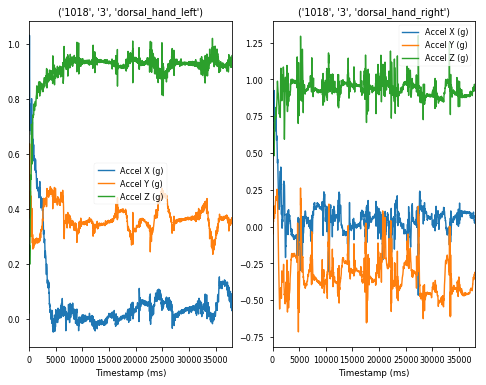

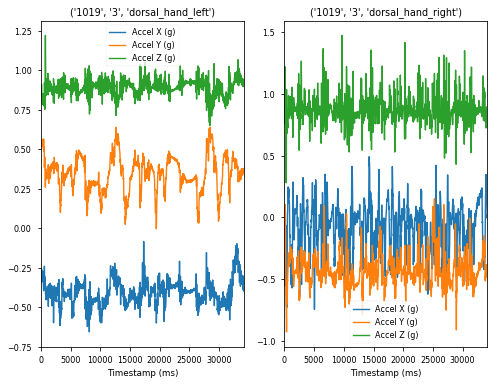

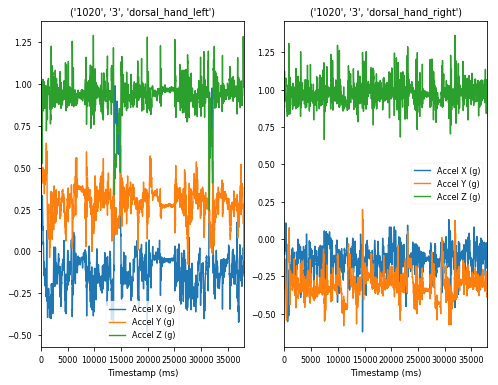

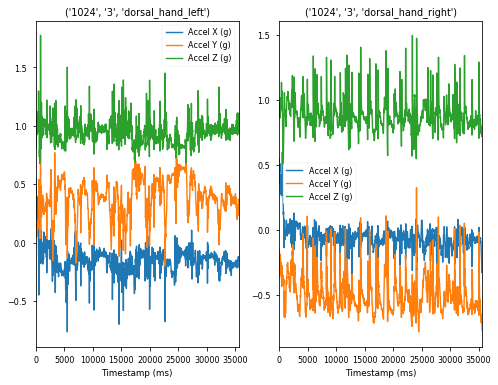

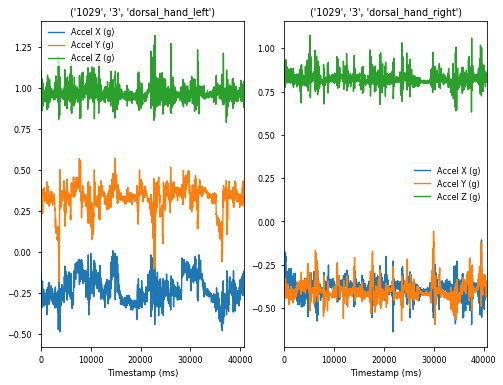

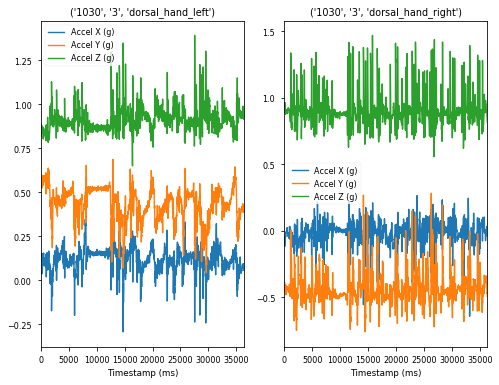

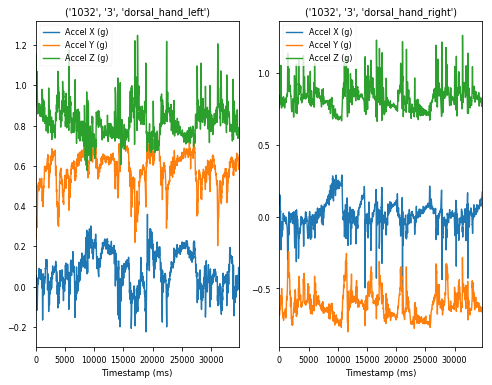

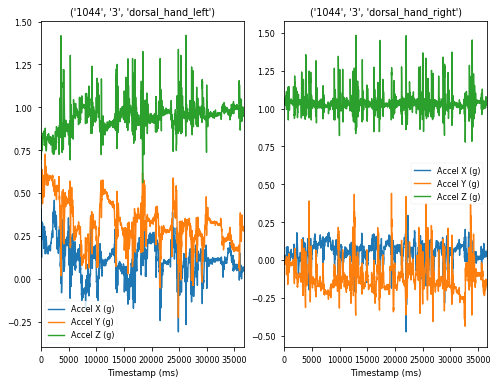

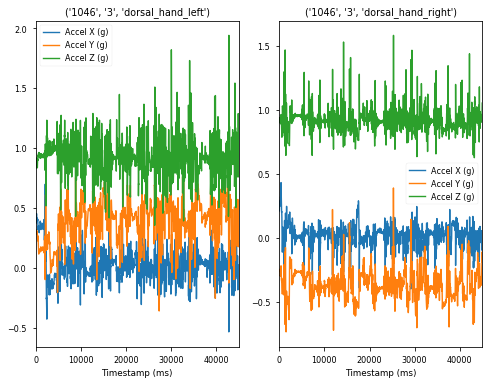

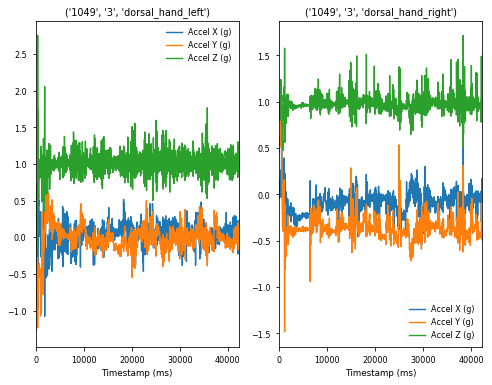

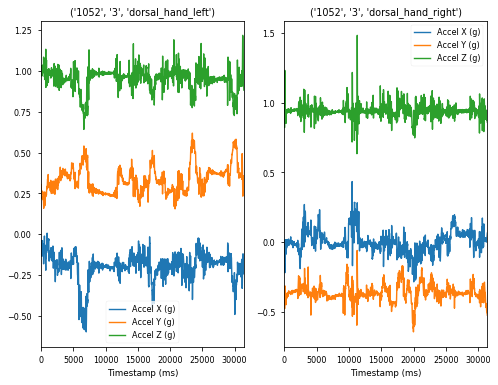

In [43]:
#load Pickle file dict
for subj in all_f:
    subj_filename = str(subj) + 'dict.pkl'
    f = open(os.path.join(path, subj_filename), 'rb')
    act_dict = pickle.load(f)
    f.close()
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,task,trial,loc1,'accel',plt_ax=ax1)
    ax1.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc1]))
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,task,trial,loc2,'accel',plt_ax=ax2)
    ax2.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc2]))

# List of activities / sensor locations

In [ ]:
sorted(list(act_dict.keys()))

In [ ]:
sorted(list(act_dict[ 'Motor #2: Walking'][0].keys()))